## One thinking: We can treat SABR model as 2D considering the symmetry, at the price of increasing the range of $\alpha_0$
https://hpcquantlib.wordpress.com/2019/10/12/almost-exact-sabr-interpolation-using-neural-networks-and-gradient-boosted-trees/

$F_t  \rightarrow \lambda F_t $

$\alpha_t \rightarrow \lambda ^{1-\beta} \alpha_t$

$\sigma(K,F_0,T,\alpha, \beta, \nu, \rho) = \sigma(\lambda K,\lambda F_0,T,\lambda ^{1-\beta}\alpha, \beta, \nu, \rho)$

With the formula above we can fix $F_0 = 1.0$ without loss of generality. We can increase the range of $\alpha_0$ to $[0,1]$

In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """

        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(12, self.width) # input channel is 3: (a(1,x),a(2,x),...,a(10,x), x, t)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2] #x for S, y for t

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## First Test: Extrapolation
T = 5

time_steps = np.linsapce(0.1,T,50)

Input data: C(alpha) for the first 10 time steps

Output data: C(alpha) for the last 40 time steps

In [51]:
################################################################
# configs
################################################################
TRAIN_PATH = 'data/SABR2D.mat'
TEST_PATH = 'data/SABR2D.mat'

ntrain = 900
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

sub = 1
S = 50 // sub
T_in = 10
T = 40

path = 'SABR2D'
path_model = 'model/'+path
t1 = default_timer()
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in).repeat([1,1,T,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0.0035, 0.0095, S), dtype=torch.float)
gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
gridt = torch.tensor(np.linspace(0.1, 5, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1]),
                       gridt.repeat([ntrain,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1]),
                       gridt.repeat([ntest,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T)

        mse = F.mse_loss(out, y, reduction='mean')

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)

pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy(),
                                             'benchmark':benchmark.cpu().numpy(),
                                              'inputs':inputs.cpu().numpy()})

torch.Size([900, 50, 40])
torch.Size([100, 50, 40])
preprocessing finished, time used: 0.1975560000000769
1188897
0 0.5076540000000023 0.44303710675901836 0.2173059974776374 0.06758240103721619
1 0.49072019999994154 0.008123545550430815 0.03218586815728081 0.018623512089252472
2 0.4876784000002772 0.0036848942852682537 0.024621970223055945 0.021438927352428437
3 0.4866501999999855 0.002822653716430068 0.01926129291454951 0.018452276587486268
4 0.4859081999998125 0.002685801226956149 0.018932193054093254 0.017684535384178163
5 0.48858659999996235 0.0037359047681093218 0.024038970437314774 0.019223878383636473
6 0.48882739999999103 0.0027951330463919376 0.02005527870522605 0.02719405472278595
7 0.49285879999979443 0.0034301498490903115 0.022995157076252833 0.020357663333415984
8 0.48588669999980993 0.005381522288856407 0.025218186709615918 0.027714632749557495
9 0.48662719999992987 0.003185332087903387 0.019787210755878026 0.023071632087230683
10 0.5067138000003979 0.0034456215979945326 

The price predicted from the model for the last 40 time steps(blue dots) and the ground truth(colored surface)

Text(0.5, 0, 'alpha')

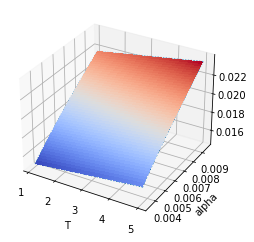

In [14]:
pred = scipy.io.loadmat('pred/SABR2D.mat')
predicted = pred['pred']
groundtruth = pred['benchmark']

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
tempx = np.linspace(0.1,5,50)
t = tempx[10:]
s = np.linspace(0.0035,0.0095,50)
N = 10
[tgrid,sgrid] = np.meshgrid(t,s)
ax.plot_surface(tgrid,sgrid,groundtruth[N,:,:].reshape(50,40),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'groundtruth')
ax.scatter(tgrid,sgrid,predicted[N,:,:].reshape(50,40),s=1,label = 'predicted')

ax.set_xlabel('T')
ax.set_ylabel('alpha')

#ax.view_init(45, 45)

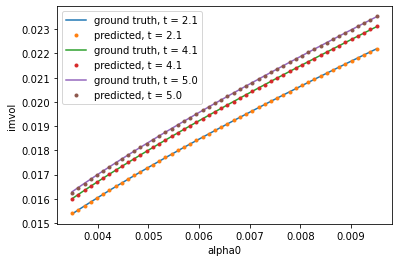

mae is 9.762555710040032e-07


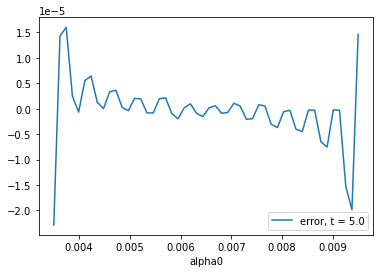

In [15]:
plt.figure()
N = 10
Nt = 10
tempx = np.linspace(0.1,5,50)
t = tempx[10:]
plt.plot(s,groundtruth[N,:,Nt],label = 'ground truth, t = ' + str(t[Nt]))
plt.plot(s,predicted[N,:,Nt],'.',label = 'predicted, t = '+ str(t[Nt]))

Nt = 30
plt.plot(s,groundtruth[N,:,Nt],label = 'ground truth, t = ' + str(t[Nt]))
plt.plot(s,predicted[N,:,Nt],'.',label = 'predicted, t = '+ str(t[Nt]))



Nt = 39
plt.plot(s,groundtruth[N,:,Nt],label = 'ground truth, t = ' + str(t[Nt]))
plt.plot(s,predicted[N,:,Nt],'.',label = 'predicted, t = '+ str(t[Nt]))

plt.xlabel('alpha0')
plt.ylabel('imvol')
plt.legend()
plt.show()


NN = 1024*50*40
mae = np.sum(np.abs(groundtruth - predicted))/NN
print('mae is ' + str(mae))

plt.figure()
N = 39
plt.plot(s,groundtruth[N,:,Nt]-predicted[N,:,Nt],label = 'error, t = ' + str(t[Nt]))
plt.xlabel('alpha0')
plt.legend()

In [16]:
################################################################
# configs
################################################################
TRAIN_PATH = 'data/SABR2D.mat'
TEST_PATH = 'data/SABR2D.mat'

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

sub = 1
S = 50// sub

T_in = 10
T = 40

index_train_u = np.ones((50,),dtype=bool)
index_train_u[::5] = False
index_train_a = ~index_train_u
#temp = np.linspace(0,49,50)
#index_train_a = temp[index_train_a]
#index_train_u = temp[index_train_u]


path = 'SABR2D_interp'
path_model = 'model/'+path
t1 = default_timer()
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,index_train_a]
train_u = reader.read_field('u')[:ntrain,::sub,index_train_u]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,index_train_a]
test_u = reader.read_field('u')[-ntest:,::sub,index_train_u]

print(train_u.shape)
print(test_u.shape)
print(test_a.shape)
print(train_a.shape)
#assert (S == train_u.shape[-2])
#assert (T == train_u.shape[-1])

a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in).repeat([1,1,T,1])


# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0.0035, 0.0095, S), dtype=torch.float)
gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
gridt = torch.tensor(np.linspace(0.1, 5, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1]),
                       gridt.repeat([ntrain,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1]),
                       gridt.repeat([ntest,1,1,1]), test_a), dim=-1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T)

        mse = F.mse_loss(out, y, reduction='mean')

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)

pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy(),
                                             'benchmark':benchmark.cpu().numpy(),
                                              'inputs':inputs.cpu().numpy()})


torch.Size([1000, 50, 40])
torch.Size([100, 50, 40])
torch.Size([100, 50, 10])
torch.Size([1000, 50, 10])
preprocessing finished, time used: 0.23318399999993744
1188897
0 0.5974019000000226 0.41429174923337997 0.2096279274225235 0.03193299949169159
1 0.5589876999999888 0.002259527110727504 0.01989304472506046 0.014998501241207123
2 0.566708399999925 0.0019863368198275565 0.02110890655219555 0.028393454551696777
3 0.5576383999998598 0.0011332129407674073 0.014717767655849456 0.00879624366760254
4 0.5660631999999168 0.0007947430905187503 0.011752496212720872 0.010847865641117095
5 0.5683638999998948 0.0018636710778810084 0.020127390295267104 0.029800031185150146
6 0.5564378999999917 0.0012242443190189078 0.016105241015553474 0.01300876721739769
7 0.564179200000126 0.000769213053281419 0.01138338503241539 0.01008421316742897
8 0.5528776999999536 0.0007515567739028484 0.01065089711546898 0.00858691319823265
9 0.5678871000000072 0.0010167522425763309 0.014653423815965653 0.01052896276116371

In [28]:
path_model

'model/SABR2D_interp'

## The Second Test: Interpolation
T = 5

time_steps = np.linsapce(0.1,T,50)

Input data: C(alpha) for the evenly spaced 10 time steps time_steps[::5]

Output data: C(alpha) for the remaining 40 time steps

Text(0.5, 0, 'S')

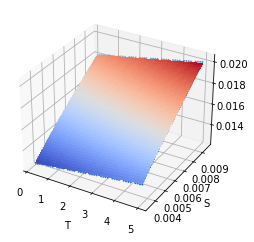

In [58]:
pred = scipy.io.loadmat('pred/SABR2D_interp.mat')
predicted = pred['pred']
groundtruth = pred['benchmark']

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
index_train_u = np.ones((50,),dtype=bool)
index_train_u[::5] = False
index_train_a = ~index_train_u
tempx = np.linspace(0.1,5,50)
t = tempx[index_train_u]
s = np.linspace(0.0035,0.0095,50)
N = 21
[tgrid,sgrid] = np.meshgrid(t,s)
ax.plot_surface(tgrid,sgrid,groundtruth[N,:,:].reshape(50,40),cmap=cm.coolwarm,
                       linewidth=1, antialiased=False,label = 'groundtruth')
ax.scatter(tgrid,sgrid,predicted[N,:,:].reshape(50,40),s=1,label = 'predicted')

ax.set_xlabel('T')
ax.set_ylabel('S')

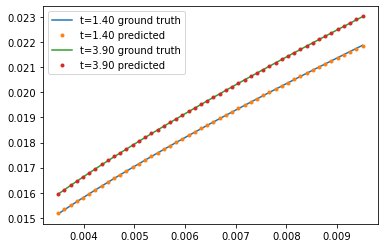

mae is 8.441527024842799e-07


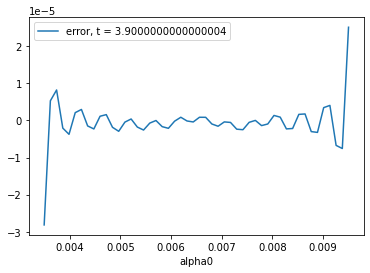

In [60]:
plt.figure()
N = 10
Nt = 10
plt.plot(s,groundtruth[N,:,Nt],label = 't='+'{:.2f}'.format(t[Nt])+' ground truth')
plt.plot(s,predicted[N,:,Nt],'.',label = 't='+'{:.2f}'.format(t[Nt])+' predicted')

Nt = 30
plt.plot(s,groundtruth[N,:,Nt],label = 't='+'{:.2f}'.format(t[Nt])+' ground truth')
plt.plot(s,predicted[N,:,Nt],'.',label = 't='+'{:.2f}'.format(t[Nt])+' predicted')

plt.legend()
plt.show()



NN = 1024*50*40
mae = np.sum(np.abs(groundtruth - predicted))/NN

print('mae is '+ str(mae))

plt.figure()
N = 39
plt.plot(s,groundtruth[N,:,Nt]-predicted[N,:,Nt],label = 'error, t = ' + str(t[Nt]))
plt.xlabel('alpha0')
plt.legend()

## make a wrapper

In [4]:
path_model = 'model/SABR2D'
model = torch.load(path_model)

In [5]:
import numpy as np
from scipy.io import savemat
from numpy import inf
from math import log, sqrt, exp, erf
from scipy.stats import norm
def lognormal_vol(k, f, t, alpha, beta, rho, volvol):
    """
    Hagan's 2002 SABR lognormal vol expansion.
    The strike k can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    # Negative strikes or forwards
    if k <= 0 or f <= 0:
        return 0.
    eps = 1e-07
    logfk = np.log(f / k)
    fkbeta = (f*k)**(1 - beta)
    a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * volvol * alpha / fkbeta**0.5
    c = (2 - 3*rho**2) * volvol**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = volvol * fkbeta**0.5 * logfk / alpha
    # if |z| > eps
    if abs(z) > eps:
        vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * _x(rho, z))
        return vz
    # if |z| <= eps
    else:
        v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
        return v0

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)


def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0


In [65]:
Tlist = np.linspace(0.1,5,50)
alpha_list= np.linspace(0.0035,0.0095,50)
f = 1.0
def wrapper(model, k, t, alpha,beta,rho, volvol):

    x = np.zeros(( 1, 50, 10))
    for i in range(10):
        for j in range(50):
            t0 = Tlist[i]
            alpha0 = alpha_list[j]
            imvol = lognormal_vol(k=k, f=f, t=t0, alpha=alpha0, beta=beta, rho=rho, volvol=volvol)
            x[0, j,i] = imvol
    with torch.no_grad():
        x = torch.tensor(x)
        x = a_normalizer.encode(x)
        x = x.reshape(1,S,1,T_in).repeat([1,1,T,1])

        # pad locations (x,y,t)

        gridx = torch.tensor(np.linspace(0.0035, 0.0095, S), dtype=torch.float)
        gridx = gridx.reshape(1, S,  1, 1).repeat([1, 1, T, 1])
        gridt = torch.tensor(np.linspace(0.1, 5, T+1)[1:], dtype=torch.float)
        gridt = gridt.reshape(1, 1,  T, 1).repeat([1, S,  1, 1])

        x = torch.cat((gridx.repeat([1,1,1,1]),
                           gridt.repeat([1,1,1,1]), x), dim=-1)
        x  = x.cuda().float()
        out = model(x).squeeze()
        out = y_normalizer.decode(out)

    ind_t = np.where(Tlist == t)[0] - 10
    ind_alpha = np.where(alpha_list == alpha)[0]

    result = out[ind_alpha, ind_t]
    return result.cpu().numpy()[0]
t = Tlist[-1]
alpha = alpha_list[25]
k = 1.2
beta = 0.2
rho = 0.2
volvol = 0.6

temp = wrapper(model = model, k = k, t = t, alpha = alpha, beta = beta, rho = rho, volvol = volvol)
temp2 = lognormal_vol(f = 1.0,   k = k, t = t, alpha = alpha, beta = beta, rho = rho, volvol = volvol)
print(temp)
print(temp2)
print(np.abs(temp - temp2))

0.0365774
0.036583975530437976
6.575710348635799e-06


Text(0, 0.5, 'mae')

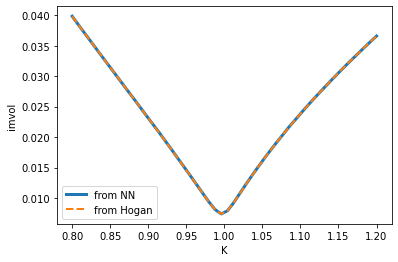

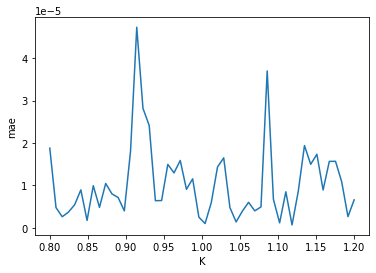

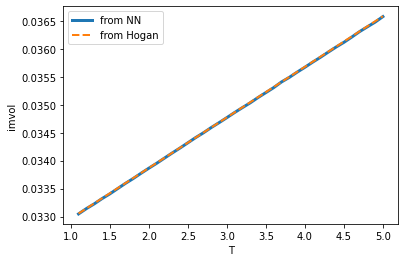

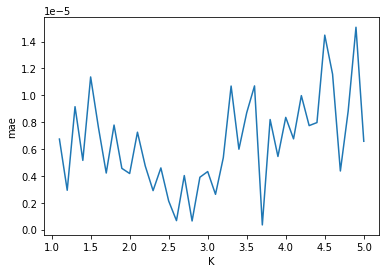

In [84]:
npoint = 50
ktest = np.linspace(0.8,1.2,npoint)
imvol = np.zeros((npoint,))
imvol2 = np.zeros((npoint,))
count = 0
for k in ktest:
    temp = wrapper(model = model, k = k, t = t, alpha = alpha, beta = beta, rho = rho, volvol = volvol)
    temp2 = lognormal_vol(f = 1.0,   k = k, t = t, alpha = alpha, beta = beta, rho = rho, volvol = volvol)
    imvol[count] = temp
    imvol2[count] = temp2
    count += 1

plt.plot(ktest,imvol,label = 'from NN',linewidth = 3)
plt.plot(ktest,imvol2, '--', label = 'from Hogan', linewidth = 2)
plt.xlabel('K')
plt.ylabel('imvol')
plt.legend()

plt.figure()
plt.plot(ktest,np.abs(imvol-imvol2))
plt.xlabel('K')
plt.ylabel('mae')

alpha = alpha_list[25]
k = 1.2
beta = 0.2
rho = 0.2
volvol = 0.6

npoint2 = 40
imvol = np.zeros((npoint2,))
imvol2 = np.zeros((npoint2,))
count = 0
for i in range(40):
    t = Tlist[i+10]
    temp = wrapper(model = model, k = k, t = t, alpha = alpha, beta = beta, rho = rho, volvol = volvol)
    temp2 = lognormal_vol(f = 1.0,   k = k, t = t, alpha = alpha, beta = beta, rho = rho, volvol = volvol)
    imvol[count] = temp
    imvol2[count] = temp2
    count += 1

plt.figure()
plt.plot(Tlist[10:],imvol,label = 'from NN',linewidth = 3)
plt.plot(Tlist[10:],imvol2, '--', label = 'from Hogan', linewidth = 2)
plt.xlabel('T')
plt.ylabel('imvol')
plt.legend()

plt.figure()
plt.plot(Tlist[10:],np.abs(imvol-imvol2))
plt.xlabel('K')
plt.ylabel('mae')


In [81]:
imvol.shape

(50,)

In [23]:
test_u.shape

torch.Size([100, 50, 40])

In [80]:
Tlist[10:].shape

(40,)